In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys  
sys.path.append("../l2hmc")
sys.path.append("../l2hmc/utils")

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from utils.distributions import random_tilted_gaussian, Gaussian, GMM, RoughWell

import seaborn as sns
sns.set_palette("muted")

In [2]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples, plot_gaussian_contours

In [3]:
# Color definition for plots
c_l2hmc, c_hmc1, c_hmc2, c_hmc3 = 'blue', 'orange', 'green', 'red'
c_true, c_contour = 'purple', '0.75'

---
# Network architecture

In [4]:
def network(x_dim, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, 100, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, 100, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, 100, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(100, 100, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(100, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(100, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(100, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net


---
# Ill-Conditioned Gaussian (ICG)

## Defining the distribution

In [18]:
x_dim = 50
mu = np.zeros(x_dim,)
cov = np.diag(np.logspace(2, -1, num=x_dim))
# cov = np.array([[100, 0], [0, 0.01]])
print(np.diag(cov))
dist = Gaussian(mu, cov)
# mu, cov = random_tilted_gaussian(x_dim)
# print(cov)

[1.00000000e+02 8.28642773e+01 6.86648845e+01 5.68986603e+01
 4.71486636e+01 3.90693994e+01 3.23745754e+01 2.68269580e+01
 2.22299648e+01 1.84206997e+01 1.52641797e+01 1.26485522e+01
 1.04811313e+01 8.68511374e+00 7.19685673e+00 5.96362332e+00
 4.94171336e+00 4.09491506e+00 3.39322177e+00 2.81176870e+00
 2.32995181e+00 1.93069773e+00 1.59985872e+00 1.32571137e+00
 1.09854114e+00 9.10298178e-01 7.54312006e-01 6.25055193e-01
 5.17947468e-01 4.29193426e-01 3.55648031e-01 2.94705170e-01
 2.44205309e-01 2.02358965e-01 1.67683294e-01 1.38949549e-01
 1.15139540e-01 9.54095476e-02 7.90604321e-02 6.55128557e-02
 5.42867544e-02 4.49843267e-02 3.72759372e-02 3.08884360e-02
 2.55954792e-02 2.12095089e-02 1.75751062e-02 1.45634848e-02
 1.20679264e-02 1.00000000e-02]
1.0000000000000124 float64


---
## Training


We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [6]:
# Leap frog integrator for Hamiltonian dynamics
dynamics = Dynamics(x_dim, dist.get_energy_function(), T=10, eps=0.1, net_factory=network)

# Losses on p(xi) and q(xi), respectively
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))
Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

# Squared jumped distance
v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
# v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

# Update loss
loss = 0.
#loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
#loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale
loss += scale * tf.reduce_mean(1.0 / v1)
loss += -tf.reduce_mean(v1) / scale

In [7]:
# Training parameters
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

Training loop described in Algorithm 1 in the paper.

In [8]:
n_steps = 5000
n_samples = 200

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0}))
sess.run(tf.global_variables_initializer())
w = sess.run(output, {x: samples})

for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))

Step: 0 / 5000, Loss: -1.13e+02, Acceptance sample: 0.57, LR: 0.00100
Step: 100 / 5000, Loss: -6.39e+02, Acceptance sample: 0.33, LR: 0.00100
Step: 200 / 5000, Loss: -9.41e+02, Acceptance sample: 0.26, LR: 0.00100
Step: 300 / 5000, Loss: -1.13e+03, Acceptance sample: 0.25, LR: 0.00100
Step: 400 / 5000, Loss: -1.32e+03, Acceptance sample: 0.28, LR: 0.00100
Step: 500 / 5000, Loss: -1.49e+03, Acceptance sample: 0.30, LR: 0.00100
Step: 600 / 5000, Loss: -1.40e+03, Acceptance sample: 0.28, LR: 0.00100
Step: 700 / 5000, Loss: -1.35e+03, Acceptance sample: 0.27, LR: 0.00100
Step: 800 / 5000, Loss: -1.42e+03, Acceptance sample: 0.31, LR: 0.00100
Step: 900 / 5000, Loss: -1.47e+03, Acceptance sample: 0.28, LR: 0.00100
Step: 1000 / 5000, Loss: -1.69e+03, Acceptance sample: 0.30, LR: 0.00096
Step: 1100 / 5000, Loss: -1.55e+03, Acceptance sample: 0.26, LR: 0.00096
Step: 1200 / 5000, Loss: -1.60e+03, Acceptance sample: 0.27, LR: 0.00096
Step: 1300 / 5000, Loss: -1.70e+03, Acceptance sample: 0.33, LR

---
## Evaluating
After training, we generate 200 chains for 2000 steps for evaluation purposes.

In [10]:
samples = dist.get_samples(n=n_samples)
final_samples = []


for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)

We compute the HMC chains with **auto-correlation spectrums** as well.

In [13]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(x_dim, 0.1, dist.get_energy_function(), sess, steps=200, samples=samples)
HMC_samples_2 = get_hmc_samples(x_dim, 0.150, dist.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(x_dim, 0.200, dist.get_energy_function(), sess, steps=2000, samples=samples)
print(HMC_samples_1.shape)

(200, 200, 50)


In [19]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

---
## Auto-correlation plot

In [36]:
HMC3[:5]

array([1.01190552, 1.01190552, 1.01190552, 1.01190552, 1.01190552])

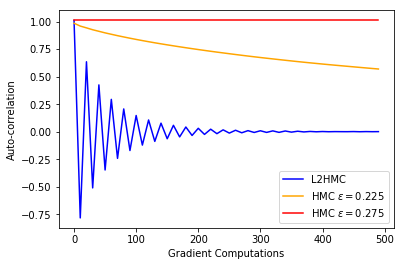

In [39]:
fig = plt.figure()
xaxis = 10 * np.arange(50)
plt.plot(xaxis, L2HMC[:50], label='L2HMC', color=c_l2hmc)
plt.plot(xaxis, HMC1[:50], label='HMC $\epsilon=0.225$', color=c_hmc1)
#plt.plot(xaxis, HMC2[:150], label='HMC $\epsilon=0.250$', color=c_hmc2)
plt.plot(xaxis, HMC3[:50], label='HMC $\epsilon=0.275$', color=c_hmc3)
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))